In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
import pysm3
import pysm3.units as u
# uses the CAMB cosmology which produced the cls
import camb
from cosmology import Cosmology
import glass
import glass.ext.camb


Simulate Synchrotron radiation using PYSM

In [2]:
def simulate_planck_maps(nside, freqs):
    """
    Simulate foreground emission and noise at different Planck frequencies.
    
    Parameters:
    nside (int): Healpix resolution parameter.
    
    Returns:
    tuple: Numpy arrays of simulated maps for synchrotron and free-free
    """    
    sens = np.array([150.,  162.,  210.,  77.4,  33.,  46.8, 154,  42.,  5016.])
    
    # Initialize PySM sky models for different foregrounds and CMB
    sky_s = pysm3.Sky(nside, preset_strings=["s1"])
    sky_f = pysm3.Sky(nside, preset_strings=["f1"])
    
    # Initialize storage for maps
    sync= []
    ff=[]
    # noise=[]
    for nf, freq in enumerate(freqs):
        # Generate noise
        # noise_pl = np.random.normal(size=(12 * nside**2)) * sens[nf] / hp.nside2resol(nside, True)
        # noise.append(noise_pl)
        
        # Convert emissions to uK_CMB
        conversion = u.K_RJ.to(u.K_CMB, equivalencies=u.cmb_equivalencies(freq * u.MHz))
        
        sync.append(sky_s.get_emission(freq * u.MHz)[0] * conversion)
        ff.append(sky_f.get_emission(freq * u.GHz)[0] * conversion)
        
    
    # Convert lists to numpy arrays (N_freq, N_pixels)
    return  np.array(sync), np.array(ff)


In [4]:
nside=256
freqs=np.arange(544,1088,step=10) #instead of steps of1MHz use 10
nfreqs=len(freqs)
lmax=3*nside -1

# creating a numpy random number generator for sampling
rng = np.random.default_rng(seed=42)

# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(
    H0=100 * h,
    omch2=Oc * h**2,
    ombh2=Ob * h**2,
    NonLinear=camb.model.NonLinear_both,
)

In [5]:
sync,ff=simulate_planck_maps(nside, freqs)
print(sync.shape)

(55, 786432)


In [7]:
np.save("/home/iloveorcas/MASS_Thesis/results_2/sync_maps.npy", sync)
np.save("/home/iloveorcas/MASS_Thesis/results_2/ff_maps.npy", ff)

In [13]:
cl_sync=np.zeros((nfreqs, lmax+1))
cl_ff=np.zeros((nfreqs, lmax+1))
# calculate the angular power spectrum for synchrotron and free-free
for i in range (nfreqs):  
    print ("processing spectra %d" % i) 
    cl_sync[i,:]= hp.anafast(sync[i,:])
    cl_ff[i,:]= hp.anafast(ff[i,:])

processing spectra 0
processing spectra 1
processing spectra 2
processing spectra 3
processing spectra 4
processing spectra 5
processing spectra 6
processing spectra 7
processing spectra 8
processing spectra 9
processing spectra 10
processing spectra 11
processing spectra 12
processing spectra 13
processing spectra 14
processing spectra 15
processing spectra 16
processing spectra 17
processing spectra 18
processing spectra 19
processing spectra 20
processing spectra 21
processing spectra 22
processing spectra 23
processing spectra 24
processing spectra 25
processing spectra 26
processing spectra 27
processing spectra 28
processing spectra 29
processing spectra 30
processing spectra 31
processing spectra 32
processing spectra 33
processing spectra 34
processing spectra 35
processing spectra 36
processing spectra 37
processing spectra 38
processing spectra 39
processing spectra 40
processing spectra 41
processing spectra 42
processing spectra 43
processing spectra 44
processing spectra 4

In [145]:
print(cl_sync.shape)

(544, 768)


In [147]:
np.save("cl_sync.npy", cl_sync)
np.save("cl_ff.npy", cl_ff)

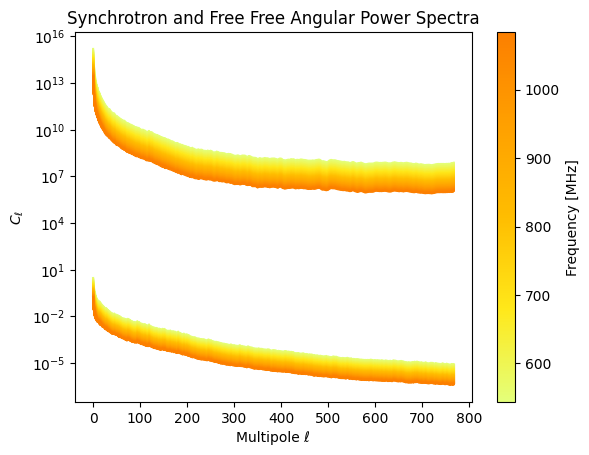

In [14]:
# Normalize for colormap
cmap = plt.get_cmap('Wistia')
norm = plt.Normalize(freqs.min(), freqs.max())

fig, ax = plt.subplots()

for i, f in enumerate(freqs):
    
    ax.plot(cl_sync[i,:], color=cmap(norm(f)))
    
    ax.plot(cl_ff[i,:], color=cmap(norm(f)))

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # dummy for older matplotlib versions
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Frequency [MHz]')

ax.set_yscale('log')
ax.set_xlabel('Multipole ℓ')
ax.set_ylabel(r'$C_\ell$')
ax.set_title('Synchrotron and Free Free Angular Power Spectra')

plt.show()

The rest-frame frequency of the 21cm line is: $ν_{21}=1420.40575$ MHz

Because of cosmic expansion, light emitted at some earlier time gets redshifted, so the observed frequency is lower than the emitted frequency:
$$1 + z = \frac{\nu_{21}}{\nu_{\text{obs}}}$$

In [9]:
z_f= (1420/544)-1
z_i= (1420/1087)-1
# set up the redshift range
# z = np.linspace(z_i, z_f, nfreqs)
print(z_i, z_f)

0.30634774609015647 1.6102941176470589


In [10]:
print(nfreqs)

55


In [11]:
def compute_matter_cls(z_i:float, z_f: float, nfreq: int, lmax:int):
    """
    Compute the matter angular power spectrum using CAMB without correlations between shells.
    
    Parameters:
    z_i (float): Initial redshift.
    z_f (float): Final redshift.
    nfreqs (int): Number of frequency channels.
    lmax (int): Maximum multipole.
    
    Returns:
    cls: Angular power spectrum
    """
    zb=glass.redshift_grid(z_i, z_f, num=nfreq)

    # triangular radial windows, equivalent to linear interpolation of n(z)
    shells = glass.linear_windows(zb, dz=0.1*(z_f-z_i)/nfreq)
    
    cli = np.zeros((len(shells), lmax + 1))

    for i in range(len(shells)):
        # Compute angular power spectrum from just one shell
        print ("processing spectra %d" % i)
        cls_i = glass.ext.camb.matter_cls(pars, lmax, [shells[i]])
        cli[i, :] = cls_i[0]  # This is Cl^i
    
    return shells, cli

In [12]:
shells_i, cls_hi=compute_matter_cls(z_i,z_f, nfreqs, lmax)
print(len(cls_hi))

/tmp/ipykernel_41958/1309664165.py:17: UserWarning: first triangular window does not start at z=0
  shells = glass.linear_windows(zb, dz=0.1*(z_f-z_i)/nfreq)


processing spectra 0
processing spectra 1
processing spectra 2
processing spectra 3
processing spectra 4
processing spectra 5
processing spectra 6
processing spectra 7
processing spectra 8
processing spectra 9
processing spectra 10
processing spectra 11
processing spectra 12
processing spectra 13
processing spectra 14
processing spectra 15
processing spectra 16
processing spectra 17
processing spectra 18
processing spectra 19
processing spectra 20
processing spectra 21
processing spectra 22
processing spectra 23
processing spectra 24
processing spectra 25
processing spectra 26
processing spectra 27
processing spectra 28
processing spectra 29
processing spectra 30
processing spectra 31
processing spectra 32
processing spectra 33
processing spectra 34
processing spectra 35
processing spectra 36
processing spectra 37
processing spectra 38
processing spectra 39
processing spectra 40
processing spectra 41
processing spectra 42
processing spectra 43
processing spectra 44
processing spectra 4

In [15]:
np.save("/home/iloveorcas/MASS_Thesis/results_2/cls_hi_uncorr.npy", cls_hi) #uncorrelated angular matter spectra C_l^i

In [16]:
print(f"Expected size: {len(shells_i) * (len(shells_i) + 1) // 2}")
print(f"cls_h size: {len(cls_hi)}")
print(len(shells_i))
print(cls_hi.shape)

Expected size: 1485
cls_h size: 54
54
(54, 768)


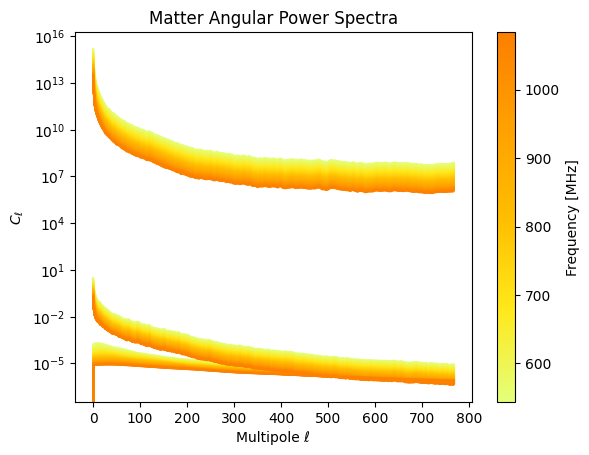

In [17]:
# Normalize for colormap
cmaps = plt.get_cmap('plasma')
norm = plt.Normalize(freqs.min(), freqs.max())

fig, ax = plt.subplots()

for i, f in enumerate(freqs[:-1]):
    ax.plot(cls_hi[i], color=cmap(norm(f)))
    ax.plot(cl_sync[i,:], color=cmap(norm(f))) #top spectra
    
    ax.plot(cl_ff[i,:], color=cmap(norm(f)))

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # dummy for older matplotlib versions
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Frequency [MHz]')

ax.set_yscale('log')
ax.set_xlabel('Multipole ℓ')
ax.set_ylabel(r'$C_\ell$')
ax.set_title('Matter Angular Power Spectra')

plt.show()

In [4]:
cls_hi = np.load("cls_hi_uncorr.npy")
sync = np.load("sync_maps.npy")
ff = np.load("ff_maps.npy")

In [18]:
hi_maps= np.zeros((nfreqs-1, 12 * nside**2))
# Generate the maps for each shell
for i in range(nfreqs-1):
    print ("processing maps %d" % i)
    hi_maps[i,:]= hp.synfast(cls_hi[i,:], nside)

processing maps 0
processing maps 1
processing maps 2
processing maps 3
processing maps 4
processing maps 5
processing maps 6
processing maps 7
processing maps 8
processing maps 9
processing maps 10
processing maps 11
processing maps 12
processing maps 13
processing maps 14
processing maps 15
processing maps 16
processing maps 17
processing maps 18
processing maps 19
processing maps 20
processing maps 21
processing maps 22
processing maps 23
processing maps 24
processing maps 25
processing maps 26
processing maps 27
processing maps 28
processing maps 29
processing maps 30
processing maps 31
processing maps 32
processing maps 33
processing maps 34
processing maps 35
processing maps 36
processing maps 37
processing maps 38
processing maps 39
processing maps 40
processing maps 41
processing maps 42
processing maps 43
processing maps 44
processing maps 45
processing maps 46
processing maps 47
processing maps 48
processing maps 49
processing maps 50
processing maps 51
processing maps 52
pro

In [20]:
all_maps= hi_maps + sync[:54] + ff[:54] #Combine all maps
print(all_maps.shape)

(54, 786432)


In [21]:
np.save("/home/iloveorcas/MASS_Thesis/results_2/contaminated_maps.npy", all_maps)
np.save("/home/iloveorcas/MASS_Thesis/results_2/hi_maps.npy", hi_maps)

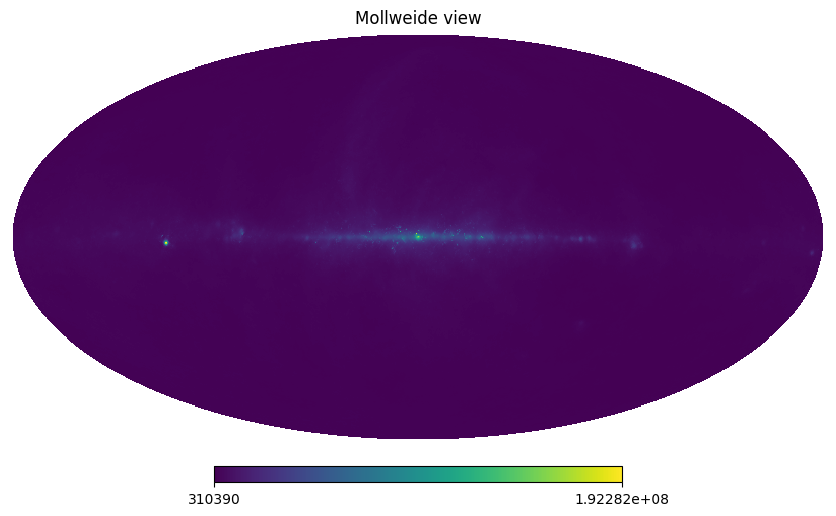

In [23]:
hp.mollview(all_maps[30])

------------------Extra Plots-----------------------------------

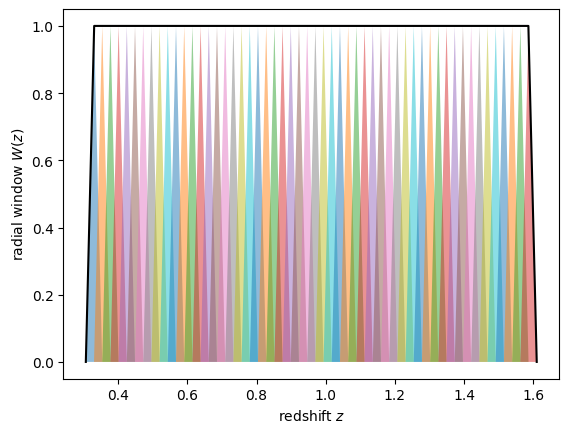

55 55


In [24]:
# plot the individual shells
for shell in shells_i:
    plt.fill_between(shell.za, np.zeros_like(shell.wa), shell.wa, alpha=0.5)

# plot the total of all shells
all_za = np.linspace(z_i, z_f, nfreqs)
all_wa = sum(np.interp(all_za, shell.za, shell.wa) for shell in shells_i)
plt.plot(all_za, all_wa, "-k")

plt.xlabel("redshift $z$")
plt.ylabel("radial window $W(z)$")
plt.show()
print(len(all_za), len(all_wa))

In [25]:
slize= int(nfreqs/4)
print(slize)
freqs_1= freqs[:slize]
freqs_2= freqs[slize:slize*2]
freqs_3= freqs[slize*2:slize*3]
freqs_4= freqs[slize*3:]
print(freqs_2)

13
[674 684 694 704 714 724 734 744 754 764 774 784 794]


In [ ]:
def compute_matter_cls_corr(z_i:float, z_f: float, nfreq: int, lmax:int):
    """
    Compute the matter angular power spectrum using CAMB with correlations between shells.
    
    Parameters:
    z_i (float): Initial redshift.
    z_f (float): Final redshift.
    nfreqs (int): Number of frequency channels.
    lmax (int): Maximum multipole.
    
    Returns:
    cls: Angular power spectrum
    """
    zb=glass.redshift_grid(z_i, z_f, num=nfreq)

    # triangular radial windows, equivalent to linear interpolation of n(z)
    shells = glass.linear_windows(zb, dz=0.1*(z_f-z_i)/nfreq)
    
    # compute angular matter power spectra with CAMB
    cls = glass.ext.camb.matter_cls(pars, lmax, shells)
    
    return shells, cls

In [ ]:
shells, cls_h=compute_matter_cls_corr(z_i,z_f, slize, lmax)

/tmp/ipykernel_189405/4232339724.py:17: UserWarning: first triangular window does not start at z=0
  shells = glass.linear_windows(zb, dz=0.1*(z_f-z_i)/nfreq)


In [ ]:
np.save("cls_h_1.npy", cls_h) #correlated C_l^ij for first 136 shells

In [ ]:
idx= glass.spectra_indices(len(shells))
x,y=idx[5]
print(x)
print(y)
print(len(idx))

2
0
9180


In [ ]:
# Initialize the array to store the full spectra
cls_full = np.zeros((slize, slize, lmax + 1))

# Loop over index pairs (i, j)
for pair in idx:
    i, j = pair  # unpack the pair
    cl_ij = glass.getcl(cls_h, i, j)  # get the C_l^{ij} spectrum
    cls_full[i, j, :] = cl_ij
    if i != j:
        cls_full[j, i, :] = cl_ij  # fill the symmetric entry

print(cls_full.shape) 

(136, 136, 768)


In [ ]:
full= np.concatenate((cls_full, cls_full, cls_full, cls_full), axis=0)
full= np.concatenate((full, full, full, full), axis=1)
print(full.shape)

(544, 544, 768)


In [ ]:
cls_f= full[0,:,:]
print(cls_f.shape)
# print(cls_f[8,:])

(544, 768)
